## Running 'ellipse':

Import required packages:

In [1]:
from astropy.io import fits
from ellipse.ellipse import Ellipse

Read test image (this is the image formerly distributed with the IRAF software as dev$pix):

In [2]:
image = fits.open("../../test/data/M51.fits")
pixel_data = image[0].data

Create an instance of the Ellipse class, passing the numpy 2-D array with the pixel data as argument:

In [3]:
ellipse = Ellipse(pixel_data)

Finally, run the fitter, getting as result a list with instances of class Isophote.

Wait until all the output prints out, down to the SMA = 0 central intensity value.

In [4]:
isophote_list = ellipse.fit_image(verbose=True)

#
# Semi-    Isophote      Ellipticity   Position    Grad.  Data  Flag  Iter. Stop
# major      mean                       Angle       rel.                    code
# axis     intensity                               error
#(pixel)                               (degree)
#
  10.00     1087.19        0.098        67.76      0.193    60    0    20     0
  11.00     1045.31        0.134        73.17      0.157    64    0    10     0
  12.10      988.67        0.157        68.42      0.158    70    0    10     0
  13.31      884.66        0.022        52.72      0.490    83    0    50     2
  14.64      857.60        0.022        52.72      0.521    91    0     3     5
  16.11      961.28        0.403        52.72      0.313    77    0    50     2
  17.72      887.29        0.358        50.58      0.145    88    0    10     0
  19.49      756.85        0.179        35.12      0.110   110    0    10     0
  21.44      681.95        0.211        35.82      0.153   119    0    10     0
  23.58  

In [5]:
type(isophote_list[-1])

ellipse.isophote.Isophote

# Plotting results:

Import packages necessary for plotting:

In [6]:
import numpy as np
import matplotlib.pyplot as plt

Basic plot of intensities as a function of (semi-major axis length) ** 1/4:

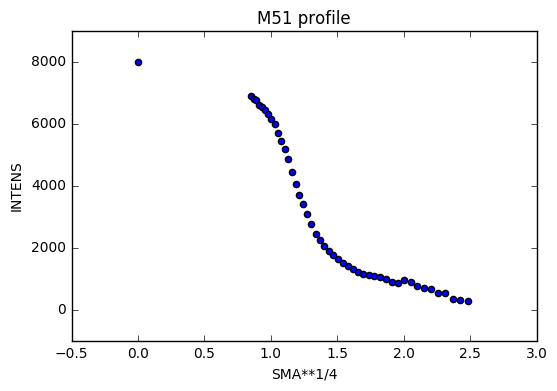

In [9]:
sma_list = []
intens_list = []

for i in range(len(isophote_list)):
    iso = isophote_list[i]

    sma_list.append(iso.sma)
    intens_list.append(iso.intens)

sma = np.array(sma_list)
intens = np.array(intens_list)

plt.scatter(sma**0.25, intens)

plt.xlabel('SMA**1/4')
plt.ylabel('INTENS')
plt.title("M51 profile")
plt.show()